# Multiprocessing in Python
**Author:** William Wyatt

**Github:** https://github.com/Tsangares

This document will be a quick overview of common pitfalls of multiprocessing with python. It should be a brief interactive example. The way this project is structured is we address the nieve approache using a `Processes` then we readdress the same project using the `Pool`. 


## Summary

 1. $N$-Dimentional Random Walk
 2. Multiprocessing Process and Queue
 3. Multiprocessing Pool


## Importing
First, we need to import the Queue and Process. This is from the `multiprocessing` library native to python.

### Quick Exposition: Process vs Thread
Python has a [lock](https://wiki.python.org/moin/GlobalInterpreterLock)  which prevent two threads from executing simultaneously:
 - `Processes` speed up programs by using multiple cores on the CPU and avoids the [lock](https://wiki.python.org/moin/GlobalInterpreterLock).
 - `Threads` are for IO tasks or tasks involving external systems because threads can combine their work more efficiently but provide no CPU intensity benefits because of the [lock](https://wiki.python.org/moin/GlobalInterpreterLock).

**We use processes!**

In [33]:
#Queue is a way to store data across processes
from multiprocessing import Queue,Process

# Random Walk: The Load
To test multiprocessing we need a function that is moderatley intense. Let's implement a $N$ dimentional random walk. In one dimention, a random walk is the position of a drunk person in an ally if they have equal probability of stepping forwards as they do stepping backwards.

To do this we import the vector libraray `numpy`, `time` to calculate the time it takes to compute, and `random` to compute our choice or direction. Lastly, we import `matplotlib` for graphs. 

In [34]:
import numpy as np
import time,random
import matplotlib.pyplot as plt

In [35]:
def random_walk(dimention=2,iterations=10_000):
    location = np.zeros(dimention)
    for i in range(iterations):
        location += np.array(random.choices([-1,1],k=dimention))
    return location
start = time.time()
location = random_walk(4,100)
print(f"We landed at {location}")
print(f'It took {time.time() - start:.06f} secconds to generate this random walk.')

We landed at [ 6.  2.  6. 20.]
It took 0.005418 secconds to generate this random walk.


# Process and Queue
In the following steps we will:
 1. Make a list to contain all the processes
 2. Make the processes
 3. Run the processes
 4. Wait for them

In [36]:
processes = [] #Container for our processes
dimention = 2 
steps = 1_000 #Walk 1,000 steps
for _ in range(20): #Make 4 processes (4 cores)
    p = Process(target=random_walk,args=(dimention,steps)) #Set the target function `random_walk`
    processes.append(p) #Store the process
    p.start()

#Now we wait for the processes to finish. 
for p in processes:
    p.join()
print("Done.")

Done.


### Wait I want the results?
The earlier process did compute all the random walks, but the results are hidden from us. Thats why we need a queue!

In [37]:
queue = Queue() #Can be accesses across processes!

#Wrap the random walk in a function that puts the result in a the queue
random_walk_with_queue = lambda d=2,k=10_000: queue.put(random_walk(d,k))

#Change the target! But otherwise the same as before
processes = []
for _ in range(20):
    p = Process(target=random_walk_with_queue)
    processes.append(p)
    p.start()
for p in processes:
    p.join()
print("Done.")

Done.


### How do I access the data in the Queue? 
Now lets unpack the queue to see it all!

In [38]:
print("Can I just see the queue?",queue,"... no")
walks = []
while not queue.empty():
    walks.append(queue.get())
print("Random Walks:", walks[:3])

Can I just see the queue? <multiprocessing.queues.Queue object at 0x7fa9bca25990> ... no
Random Walks: [array([-46.,  14.]), array([48., 38.]), array([206., -16.])]


Great we have the positions now, but lets look at it in a scatter plot.

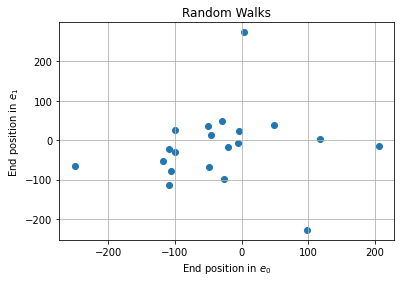

In [39]:
#PYTHON TRICK!
#Transpose the data from a list of points, into two lists of x coordiantes and y coordinates
x,y = zip(*walks) 

#Plotting
plt.title("Random Walks")
plt.xlabel("End position in $e_0$")
plt.ylabel("End position in $e_1$")
plt.scatter(x,y)
plt.grid()
plt.show()

## Yo that all kinda sucks... is there a better way
**Yes Multiprocessing POOL***
# Multiprocessing Pool
Now we do the same as above but using a multiprocessing pool. It should be a lot better.

In [40]:
from multiprocessing import Pool

Before we do the random walk, lets to an even simpler example. Printing a number, given a number.

In [41]:
def what_number(number):
  print(f"This number {number}\n")
  return number

Now we run this 10 times using a multiprocesing pool.

In [42]:
# Run 8 parallel processes
with Pool(8) as pool:
  numbers = pool.map(what_number,range(10))
print(numbers)

This number 5
This number 3
This number 6
This number 7
This number 2
This number 0




This number 4
This number 1


This number 8
This number 9




[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Takeaway
The pool will run the target function given a `list` of arguments. What happens when there is no list of arguments like our random walk? The walk takes in constants, the dimention and iteration. You can either generate a list copying the dimention and iteration or use generator like I will show you.

First though, I need to wrap my function with an input for an index to allow my function to be finite otherwise it will be an infinite loop.

In [43]:
#Wrap random walk with an index argument
def random_walk_indexed(index,dimention,iterations):
    return random_walk(dimention,iterations)

In [44]:
#To repeat a constant in a list you use thir itertools.repeat
from itertools import repeat

dimention = 3
iterations = 10_000
vectors = 100

#Boom 100 vectors in 3D with 8 processes!
#Pool immediatley stores the results in a list called `vec`
with Pool(8) as pool:
    vecs = pool.starmap(random_walk_indexed, zip(range(vectors),repeat(dimention),repeat(vectors)))

Now we can just look at our results:

In [45]:
print(vecs[:5])

[array([-14., -18.,  10.]), array([-10.,  -2.,   0.]), array([ 2.,  8., 16.]), array([4., 8., 6.]), array([  0.,  -4., -12.])]


### 3D Plotting!

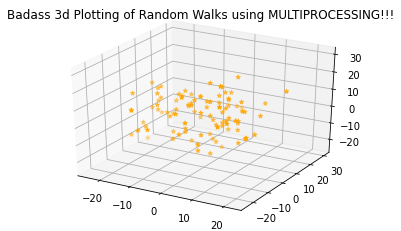

In [46]:
x,y,z = zip(*vecs)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z,marker='*',color='orange')
plt.title("Badass 3d Plotting of Random Walks using MULTIPROCESSING!!!")
plt.show()

# Please Help ME!
If you enjoyed this project please star it on my github repository:
[github.com/Tsangares](https://github.com/Tsangares?tab=repositories)

Star projects of mine you enjoy to help me stand out and I will continue to make great **free** tutorials and **free** projects for the community. 